In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import sys
import pathlib

PROJECT_ROOT = pathlib.Path().cwd().parent
sys.path.append(str(PROJECT_ROOT))

image_path = PROJECT_ROOT / 'ReMIND2Reg_dataset' / 'imagesTr'

from src.utils import *
from src.datatype import MRIDataset, iUSDataset
from src.renderer import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import torch.nn.functional as F
from sklearn.cluster import KMeans

patient_id = "005" # between 000 and 102, t1 and t2 don't exist for all patients
iUS_file = f"ReMIND2Reg_0{patient_id}_0000.nii.gz"
t1_file = f"Subj-1-mri-T1w-Defaced.nii"
t2_file = f"ReMIND2Reg_0{patient_id}_0002.nii.gz"

dataset = MRIDataset([image_path / t1_file], "T1", axis=0)
T1 = dataset[0]
T1_volume = T1["image"].squeeze(0)       # (D,H,W)

US = iUSDataset(image_path / iUS_file, "iUS", axis=0)
# dataset = MRIDataset([image_path / t1_file], "T1", axis=0)

In [31]:
# Plot histograms
def plot_histogram(volume):
    plt.figure(figsize=(12, 6))

    plt.hist(volume.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title('T1 Volume Intensity Distribution')
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')
    # plt.xlim(0,20)

    plt.tight_layout()
    plt.show()

In [32]:
import numpy as np
from scipy.ndimage import binary_dilation, binary_erosion

def create_brain_mask(volume, threshold=50):
    """
    Quick brain mask generation by thresholding and cleaning.
    volume: np.ndarray, MRI volume
    threshold: int, intensity below which is considered air/background
    """
    mask = volume > threshold
    mask = binary_dilation(mask, iterations=2) # pourquoi?
    mask = binary_erosion(mask, iterations=2) # pourquoi? 
    return torch.from_numpy(mask)

def zscore_normalize(volume, mask):
    """
    Normalize a volume by z-scoring inside a brain mask.
    Args:
        volume: torch.Tensor, the 3D volume to normalize.
        mask: torch.Tensor, binary brain mask of the same shape as the volume.
    
    Returns:
        torch.Tensor: The z-score normalized volume.
    """
    volume = volume.float()
    brain_voxels = volume[mask > 0]
    mean = brain_voxels.mean()
    std = brain_voxels.std()
    
    volume_norm = (volume - mean) / (std + 1e-8)  
    return volume_norm



In [33]:
import torch.nn as nn

class ImpedanceEstimator(nn.Module):
    """MLP for estimating acoustic impedance from normalized intensity values."""
    def __init__(self, input_dim: int = 1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32), nn.ReLU(),
            nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    @classmethod
    def train_model(cls,
                    X: torch.Tensor,
                    y: torch.Tensor,
                    input_dim: int = 1,
                    lr: float = 1e-3,
                    epochs: int = 5000) -> 'ImpedanceEstimator':
        """Train impedance estimation model on paired data."""
        model = cls(input_dim)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        loss_fn = nn.MSELoss()
        
        for _ in range(epochs):
            optimizer.zero_grad()
            loss = loss_fn(model(X), y)
            loss.backward()
            optimizer.step()
            
        return model

    @staticmethod
    def compute_impedance_volume(
        volume: torch.Tensor,
        model: 'ImpedanceEstimator',
        threshold: float = 50
    ) -> torch.Tensor:
        """Generate full impedance volume using trained model and preprocessing."""
        mask = create_brain_mask(volume, threshold)
        vol_norm = zscore_normalize(volume.float(), mask)
        
        with torch.no_grad():
            Z_pred = model(vol_norm[mask].unsqueeze(1)).squeeze() * 1e6
            
        Z_vol = torch.full_like(volume, 400.0)  # Default air impedance
        Z_vol[mask] = Z_pred
        return Z_vol

In [34]:
T1_data = pd.DataFrame(
    {"organ": ["fat","liver","muscle","BWM","BGM","CSF","AIR"],
     "intensity": [260,500,870,780,920,2500, 0], 
     "impedance": [1.34e6,1.67e6,1.68e6,1.6e6,1.6e6,1.5e6, 0.0004e6]}
)

In [35]:

T1_volume = T1_volume.float()

# t1 = np.array([-2.0, -1.0, 0.0,  1.5]).reshape(-1,1)
t1 = T1_data['intensity'].values.reshape(-1,1)
t2 = np.array([-2.0, -0.5, 0.0,  2.0]).reshape(-1,1)
# z1 = np.array([400,  1.52e6, 1.7e6, 1.38e6]).reshape(-1,1)/1e6
z1 = T1_data['impedance'].values.reshape(-1,1)
z2 = np.array([400,  1.38e6, 1.7e6, 1.52e6]).reshape(-1,1)/1e6

X1 = torch.tensor(t1, dtype=torch.float32)
Y1 = torch.tensor(z1, dtype=torch.float32)
X2 = torch.tensor(t2, dtype=torch.float32)
Y2 = torch.tensor(z2, dtype=torch.float32)

model_t1 = ImpedanceEstimator.train_model(X1, Y1, input_dim=1)
model_t2 = ImpedanceEstimator.train_model(X2, Y2, input_dim=1)

Z_vol = ImpedanceEstimator.compute_impedance_volume(T1_volume, model_t1, threshold=50)

In [36]:
UR = UltrasoundRenderer(150, 0.0001)

angle = 40  # degrees
rays = 200

thetas = np.radians(np.linspace(-angle,angle, rays))  # 64 rays across the fan
directions = [np.array([np.sin(theta), np.cos(theta), 0]) for theta in thetas]

In [37]:
model = lambda x: UR.plot_beam_frame(
    volume=Z_vol,
    source=torch.tensor(x),
    directions=torch.tensor(directions),
    angle=25
)


In [38]:
def plot_beam_frame(
        volume: torch.Tensor,
        source: torch.Tensor,
        directions: torch.Tensor,
        angle: float = 45.0,
        plot: bool = True,
        MRI : bool = False,
        ax: plt.Axes = None,
        **kwargs
    ):
        """
        Simulates rays and plots the resulting ultrasound fan frame.
        
        Args:
            volume: (D, H, W) Tensor, ultrasound volume (acoustic impedance)
            source: (3,) Tensor, starting position of rays
            directions: (N_rays, 3) Tensor of ray directions (unit vectors)
            angle: fan angle (degrees), used for plotting geometry
        """
        # 1. Simulate reflection coefficients
        R = UR.simulate_rays(
            volume=volume,
            source=source,
            directions=directions,
            MRI=MRI,
        )

        

        # attenuation!
        attenuation_coeff = 0.0001
        depths = torch.arange(150, device=R.device).float()
        attenuation = torch.exp(-attenuation_coeff * depths)  # shape (num_samples,)
        if not MRI:
            
            processed_output = prop_tent(R) * attenuation  # (N_rays, num_samples-1, 2*(num_samples-1))
        else:
            print("MRI Plot so less processing")
            processed_output = R
        if not plot:
            return processed_output

        processed_output_torch = processed_output.clone()        
        processed_output = processed_output.detach().cpu().numpy()

        # proceed only if requires plotting
        # 2. Convert to numpy
        n_rays, n_samples = processed_output.shape

        # 3. Compute ray geometry
        source_2d = np.array([128, 0])  # (x, z), assuming 2D fan centered at (128, 0)
        thetas = np.radians(np.linspace(-angle, angle, n_rays))  # shape (n_rays,)
        ray_len = n_samples  # number of points along each ray

        # Vectorized generation of all points
        steps = np.arange(ray_len)  # (n_samples,)

        directions_xz = np.stack([
            np.sin(thetas),   # (n_rays,)
            np.cos(thetas)    # (n_rays,)
        ], axis=1)  # (n_rays, 2)

        # Expand dimensions
        steps = steps[None, :, None]              # (1, n_samples, 1)
        directions_xz = directions_xz[:, None, :]  # (n_rays, 1, 2)

        points = source_2d[None, None, :] + steps * directions_xz  # (n_rays, n_samples, 2)

        x_coords = points[..., 0].flatten()
        z_coords = points[..., 1].flatten()
        intensities = processed_output.flatten()

        # 4. Plot
        if ax is not None:
            ax.clear()
            
            ax.set_facecolor('black')
            ax.scatter(x_coords, z_coords, c=intensities, s=1, **kwargs)
            ax.set_xlabel("X")
            ax.set_ylabel("Z")
            ax.set_title("Fan-shaped Ultrasound Frame")
        else:
            plt.figure(figsize=(5, 5*np.tan(angle*np.pi/180)))
            plt.rcParams['axes.facecolor'] = 'black'
            plt.scatter(x_coords, z_coords, c=intensities, s=1, **kwargs)
            plt.gca().set_aspect('equal')
            plt.xlabel("X")
            plt.ylabel("Z")
            plt.title("Fan-shaped Ultrasound Frame")
            plt.show()

        # 4. 
        return processed_output_torch


In [39]:
def prop_ruff(refLR: torch.Tensor) -> torch.Tensor:
    """
    Solve the 2(N+1)×2(N+1) system for *each* ray in the batch.

    Parameters
    ----------
    refLR : (B, N)  reflection coeffs for incidence from the left

    Returns
    -------
    w : (B, 2*(N+1)) laid out as [g0, d0, g1, d1, …, gN, dN]
    """
    B, N = refLR.shape
    traLR = 1 + refLR              # t_il
    traRL = 1 - refLR              # t_ir
    refRL = -refLR                 # r_rl  (OK only if impedances equal)

    size = 2 * (N + 1)
    A = torch.zeros((B, size, size), dtype=refLR.dtype, device=refLR.device)
    b = torch.zeros((B, size),      dtype=refLR.dtype, device=refLR.device)

    # boundary conditions: g0 = 1 , d_{N+1}=0
    b[:, 0] = 1
    A[:, 0, 0]   = 1
    A[:, -1, -1] = 1

    for i in range(N):
        gi,  di   = 2 * i,     2 * i + 1          # positions inside the vector
        gip1, dip1 = 2 * (i + 1), 2 * (i + 1) + 1

        # Eq. 1 :  g_{i+1} - t_il g_i - r_lr d_{i+1} = 0
        A[:, gip1, gi]   = -traLR[:, i]           # –t_il g_i
        A[:, gip1, dip1] = -refLR[:, i]           # –r_lr d_{i+1}
        A[:, gip1, gip1] =  1                     # +g_{i+1}

        # Eq. 2 :  d_i - r_rl g_i - t_ir d_{i+1} = 0
        A[:, di, gi]     = -refRL[:, i]           # –r_rl g_i
        A[:, di, dip1]   = -traRL[:, i]           # –t_ir d_{i+1}
        A[:, di, di]     =  1                     # +d_i

    w = torch.linalg.solve(A, b)                  # (B, 2*(N+1))
    return w

def prop_tent(refLR: torch.Tensor) -> torch.Tensor:
    """
    For each truncation depth i = 0..N compute the surface-return amplitude d0^{(i)}.

    Parameters
    ----------
    refLR : (B, N)  reflection coeffs for incidence from the left

    Returns
    -------
    d0_per_depth : (B, N+1)  with d0^{(0)}, d0^{(1)}, …, d0^{(N)}
    """
    print(refLR.shape)
    B, N = refLR.shape
    d0_per_depth = []
    total = []
    for i in range(N + 1):
        w = prop_ruff(refLR[:, :i])        # solve the truncated system
        d0_per_depth.append(w[:, 1])       # column 1 is d0
        total.append(w)
    # return total
    return torch.stack(d0_per_depth, dim=1)   # (B, N+1)  ## FIX THIS


In [40]:
patient_id = "005" # between 000 and 102, t1 and t2 don't exist for all patients
iUS_file = f"ReMIND2Reg_0{patient_id}_0000.nii.gz"
t1_file = f"ReMIND2Reg_0{patient_id}_0001.nii.gz"
t2_file = f"ReMIND2Reg_0{patient_id}_0002.nii.gz"

dataset = MRIDataset([image_path / t1_file], "T1", axis=0)
T1 = dataset[0]
T1_volume = T1["image"].squeeze(0)       # (D,H,W)

US = iUSDataset(image_path / iUS_file, "iUS", axis=0)

T1_volume = T1_volume.float()

# t1 = np.array([-2.0, -1.0, 0.0,  1.5]).reshape(-1,1)
t1 = T1_data['intensity'].values.reshape(-1,1)
t2 = np.array([-2.0, -0.5, 0.0,  2.0]).reshape(-1,1)
# z1 = np.array([400,  1.52e6, 1.7e6, 1.38e6]).reshape(-1,1)/1e6
z1 = T1_data['impedance'].values.reshape(-1,1)
z2 = np.array([400,  1.38e6, 1.7e6, 1.52e6]).reshape(-1,1)/1e6

X1 = torch.tensor(t1, dtype=torch.float32)
Y1 = torch.tensor(z1, dtype=torch.float32)
X2 = torch.tensor(t2, dtype=torch.float32)
Y2 = torch.tensor(z2, dtype=torch.float32)

model_t1 = ImpedanceEstimator.train_model(X1, Y1, input_dim=1)
model_t2 = ImpedanceEstimator.train_model(X2, Y2, input_dim=1)

Z_vol = ImpedanceEstimator.compute_impedance_volume(T1_volume, model_t1, threshold=50)

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

def create_custom_colormap():
    """
    Return a simple gray-to-white LinearSegmentedColormap.
    """
    # list of colors in order of appearance (start → end)
    colors = ['#2e2e2e',  # dark gray
              '#ffffff'][::-1]   # white
    
    # .from_list is the clean way to build a colormap from a list of hex codes
    return LinearSegmentedColormap.from_list('CustomGrayWhite', colors)

map = create_custom_colormap()

angle = 30  # degrees
rays = 200

us_slides = np.rot90(US.data[:,:,55], 1)

thetas = np.radians(np.linspace(-angle,angle, rays))  # 64 rays across the fan

directions = [np.array([-np.cos(theta), np.sin(theta),  0]) for theta in thetas]

fig, ax = plt.subplots(1, 3, figsize=(10, 5))

ax[0].imshow(np.rot90(T1_volume[:,:,55]),cmap='gray')
ax[0].set_title("T1 Volume")

# ax[0].axis('off')   
ax[2].set_title("US Slice")
# ax[2].axis('off')
ax[2].imshow(us_slides,cmap='gray')

res =  UR.plot_beam_frame(
    volume=Z_vol,
    source=torch.tensor([200.,150,55]),
    directions=torch.tensor(directions),
    angle=angle,
    ax = ax[1],
    
);
ax[1].set_aspect('equal')


In [42]:
torch.tensor(directions).shape, torch.tensor([directions[0]]).shape

(torch.Size([200, 3]), torch.Size([1, 3]))

In [43]:
# res =  plot_beam_frame(
#     volume=Z_vol,
#     source=torch.tensor([200.,150,55]),
#     directions=torch.tensor(directions),
#     angle=angle,
#     ax = ax[1],
#     cmap=map,
# );
res_10 = []
for x in res:
    res_10. append(x[110,1])

IndexError: too many indices for tensor of dimension 1

tensor([ 0.0000e+00,  8.2176e-05,  1.1908e-03,  1.3264e-02,  1.6591e-02,
         1.6603e-02,  1.4693e-02,  1.4678e-02,  1.4147e-02,  1.1626e-02,
         1.0373e-02,  1.2738e-02,  1.4764e-02,  1.5685e-02,  1.6273e-02,
         1.6570e-02,  1.6624e-02,  1.6627e-02,  1.6627e-02,  1.6434e-02,
         1.5487e-02,  1.3589e-02,  1.4597e-02,  1.6480e-02,  1.6625e-02,
         1.6519e-02,  1.6431e-02,  1.6487e-02,  1.6162e-02,  1.4644e-02,
         1.3614e-02,  1.3003e-02,  1.2699e-02,  1.2614e-02,  1.2590e-02,
         1.2544e-02,  1.2364e-02,  1.2054e-02,  1.2442e-02,  1.2986e-02,
         1.2879e-02,  1.2654e-02,  1.2873e-02,  1.3073e-02,  1.2788e-02,
         1.2509e-02,  1.3079e-02,  1.3637e-02,  1.3528e-02,  1.3363e-02,
         1.3198e-02,  1.3083e-02,  1.3183e-02,  1.3296e-02,  1.3270e-02,
         1.3137e-02,  1.2914e-02,  1.2787e-02,  1.2886e-02,  1.3111e-02,
         1.3551e-02,  1.4266e-02,  1.5176e-02,  1.5663e-02,  1.5764e-02,
         1.5812e-02,  1.5856e-02,  1.5784e-02,  1.5

In [ ]:
make_pyramid(ref_LR_10).shape, len(res_10)

(torch.Size([149, 149]), 150)

In [ ]:
torch.max(pyramid.nan_to_num(0)), torch.min(pyramid.nan_to_num(0)), torch.max(column), torch.min(column)

(tensor(0.0170), tensor(-0.0201), tensor(0.0167), tensor(-0.0265))

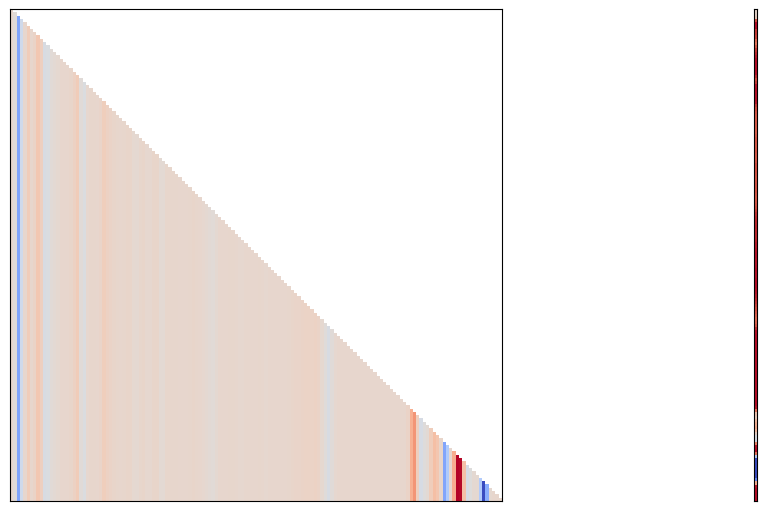

In [ ]:
ref_LR_10 = ref_LR[110,:]
def make_pyramid(ref_LR: torch.Tensor, pad_value=float('nan')) -> torch.Tensor:
    """
    Build a pyramid array from a 1D tensor by stacking [0:i] slices.
    Result is a 2D array of shape (N, N), padded with NaNs or other fill value.
    """
    N = ref_LR.shape[0]
    pyramid = torch.full((N, N), pad_value, dtype=ref_LR.dtype)

    for i in range(1, N + 1):
        pyramid[i - 1, :i] = ref_LR[:i]

    return pyramid

# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].set_xticks([])
# ax[0].set_yticks([])
# ax[0].imshow(, cmap='gray')
# ax[1].set_xticks([])
# ax[1].set_yticks([])
# ax[1].imshow(torch.tensor(res_10).reshape(1,-1).T, cmap='gray')

# Plot
pyramid = make_pyramid(ref_LR_10)
column = torch.tensor(res_10).reshape(1, -1).T
vmin = torch.min(pyramid.nan_to_num(0))
vmax = torch.max(pyramid.nan_to_num(0))

# Use either constrained_layout or manual spacing (not both)
fig, ax = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'wspace': 0}, constrained_layout=True)

# Plot pyramid
ax[0].imshow(pyramid, cmap='coolwarm', aspect='auto', vmin=vmin, vmax=vmax)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Plot column (transposed view of res_10)
ax[1].imshow(column, cmap='coolwarm', vmin=vmin, vmax=vmax)
ax[1].set_xticks([])
ax[1].set_yticks([])

# Optional: small space between title and plots
# fig.suptitle("Pyramid of Reflected Coefficients", y=0.95)

plt.show()

In [ ]:
res_10

[tensor([1., 0.]),
 tensor([1.0000e+00, 7.8219e-04, 9.9922e-01, 0.0000e+00]),
 tensor([1.0000e+00, 2.3638e-03, 9.9922e-01, 1.5804e-03, 9.9764e-01, 1.3216e-10]),
 tensor([ 1.0000e+00,  8.4540e-03,  9.9921e-01,  7.6658e-03,  9.9762e-01,
          6.0758e-03,  9.9155e-01, -1.6417e-10]),
 tensor([1.0000, 0.0153, 0.9992, 0.0145, 0.9976, 0.0129, 0.9915, 0.0068, 0.9847,
         0.0000]),
 tensor([1.0000, 0.0166, 0.9992, 0.0158, 0.9976, 0.0142, 0.9915, 0.0081, 0.9847,
         0.0013, 0.9834, 0.0000]),
 tensor([ 1.0000e+00,  1.6613e-02,  9.9921e-01,  1.5818e-02,  9.9760e-01,
          1.4215e-02,  9.9148e-01,  8.0903e-03,  9.8465e-01,  1.2651e-03,
          9.8337e-01, -1.3432e-05,  9.8339e-01,  0.0000e+00]),
 tensor([ 1.0000e+00,  1.5947e-02,  9.9921e-01,  1.5153e-02,  9.9760e-01,
          1.3551e-02,  9.9148e-01,  7.4298e-03,  9.8466e-01,  6.0910e-04,
          9.8338e-01, -6.6863e-04,  9.8340e-01, -6.5521e-04,  9.8405e-01,
          0.0000e+00]),
 tensor([ 1.0000e+00,  1.4939e-02,  9.9921

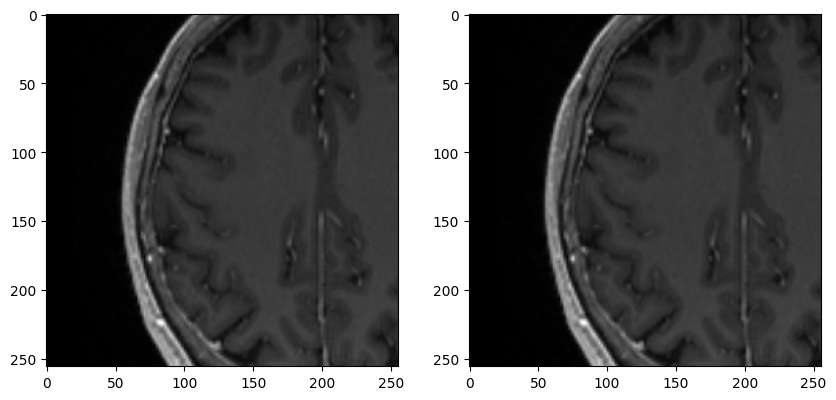

In [ ]:
R = []
for x in range(0,256,1):
    R.append(UR.trace_ray(
        volume=T1['image'].squeeze(0),
        source=torch.tensor([x,0.,55]),
        directions=torch.tensor([0,1,0]),
        num_samples=256,
    ))
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(T1_volume[:,:,55].T, cmap='gray')
ax[1].imshow(torch.stack(R).T, cmap='gray')